In [1]:
from langsmith import traceable

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """ 
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
     
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
     
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content: 
            char_limit = max_tokens_per_source * 4 
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

In [2]:
def format_sources(search_results):
    """Format search results into a bullet-point list of sources.
    
    Args:
        search_results (dict): Tavily search response containing results
        
    Returns:
        str: Formatted string with sources and their URLs
    """
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )

In [3]:
from tavily import TavilyClient

# Initialize Tavily client with your API key
TAVILY_API_KEY = "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"
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)


In [4]:
@traceable
def tavily_search(query, include_raw_content=True, max_results=3):
    """ Search the web using the Tavily API.
    
    Args:
        query (str): The search query to execute
        include_raw_content (bool): Whether to include the raw_content from Tavily in the formatted string
        max_results (int): Maximum number of results to return
        
    Returns:
        dict: Tavily search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""
     
    return tavily_client.search(query, 
                         max_results=max_results, 
                         include_raw_content=include_raw_content)

In [5]:
from langchain_ollama import ChatOllama

local_llm = "gemma3:4b"
local_llm = "llama3.2:latest"

llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

In [6]:
import operator
from dataclasses import dataclass, field
from typing_extensions import TypedDict, Annotated, Literal

@dataclass(kw_only=True)
class SummaryState:
    research_topic: str = field(default=None)
    search_query: str = field(default=None)
    web_research_results: Annotated[list, operator.add] = field(default_factory=list) 
    sources_gathered: Annotated[list, operator.add] = field(default_factory=list)
    research_loop_count: int = field(default=0)
    running_summary: str = field(default=None)

@dataclass(kw_only=True)
class SummaryStateInput(TypedDict):
    research_topic: str = field(default=None)

@dataclass(kw_only=True)
class SummaryStateOutput(TypedDict):
    running_summary: str = field(default=None)

In [7]:
import json
from langchain_core.runnables import RunnableConfig
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from configuration import Configuration

In [8]:
query_writer_instructions="""Your goal is to generate targeted web search query.

The query will gather information related to a specific topic.

Topic:
{research_topic}

Return your query as a JSON object:
{{
    "query": "string",
    "aspect": "string",
    "rationale": "string"
}}
"""

In [9]:
summarizer_instructions="""Your goal is to generate a high-quality summary of the web search results.

When EXTENDING an existing summary:
1. Seamlessly integrate new information without repeating what's already covered
2. Maintain consistency with the existing content's style and depth
3. Only add new, non-redundant information
4. Ensure smooth transitions between existing and new content

When creating a NEW summary:
1. Highlight the most relevant information from each source
2. Provide a concise overview of the key points related to the report topic
3. Emphasize significant findings or insights
4. Ensure a coherent flow of information

In both cases:
- Focus on factual, objective information
- Maintain a consistent technical depth
- Avoid redundancy and repetition
- DO NOT use phrases like "based on the new results" or "according to additional sources"
- DO NOT add a preamble like "Here is an extended summary ..." Just directly output the summary.
- DO NOT add a References or Works Cited section.
"""

In [10]:
reflection_instructions = """You are an expert research assistant analyzing a summary about {research_topic}.

Your tasks:
1. Identify knowledge gaps or areas that need deeper exploration
2. Generate a follow-up question that would help expand your understanding
3. Focus on technical details, implementation specifics, or emerging trends that weren't fully covered

Ensure the follow-up question is self-contained and includes necessary context for web search.

Return your analysis as a JSON object:
{{ 
    "knowledge_gap": "string",
    "follow_up_query": "string"
}}"""

In [11]:
def generate_query(state: SummaryState):
    query_writer_instructions_formatted = query_writer_instructions.format(research_topic=state.research_topic)
    result = llm_json_mode.invoke(
        [SystemMessage(content=query_writer_instructions_formatted),
         HumanMessage(content=f"Generate a query for web search:")]
    )
    query = json.loads(result.content)

    return {"search_query": query['query']}

In [12]:
def web_research(state: SummaryState):
    search_results = tavily_search(state.search_query, include_raw_content=True, max_results=1)
    search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000)

    return {"sources_gathered": [format_sources(search_results)], "research_loop_count": state.research_loop_count + 1, "web_research_results": [search_str]}

def summarize_sources(state: SummaryState):
    existing_summary = state.running_summary
    most_recent_web_research = state.web_research_results[-1]

    if existing_summary:
        human_message_content = (
            f"Extend the existing summary: {existing_summary}\n\n"
            f"Include new search results: {most_recent_web_research}"
            f"That addresses the following topic: {state.research_topic}"
        )
    else:
        human_message_content = (
            f"Generate a summary of these search results: {most_recent_web_research} "
            f"That addresses the following topic: {state.research_topic}"
        )
 
    result = llm.invoke(
        [SystemMessage(content=summarizer_instructions),
        HumanMessage(content=human_message_content)]
    )

    running_summary = result.content
    return {"running_summary": running_summary}

def reflect_on_summary(state: SummaryState):
    result = llm_json_mode.invoke(
        [SystemMessage(content=reflection_instructions.format(research_topic=state.research_topic)),
        HumanMessage(content=f"Identify a knowledge gap and generate a follow-up web search query based on our existing knowledge: {state.running_summary}")]
    )   
    follow_up_query = json.loads(result.content)

    return {"search_query": follow_up_query['follow_up_query']}

def finalize_summary(state: SummaryState):
    all_sources = "\n".join(source for source in state.sources_gathered)
    state.running_summary = f"## Summary\n\n{state.running_summary}\n\n ### Sources:\n{all_sources}"
    return {"running_summary": state.running_summary}

def route_research(state: SummaryState, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    configurable = Configuration.from_runnable_config(config)
    if state.research_loop_count <= configurable.max_web_research_loops:
        return "web_research"
    else:
        return "finalize_summary" 

In [13]:
builder = StateGraph(SummaryState, input=SummaryStateInput, output=SummaryStateOutput, config_schema=Configuration)
builder.add_node("generate_query", generate_query)
builder.add_node("web_research", web_research)
builder.add_node("summarize_sources", summarize_sources)
builder.add_node("reflect_on_summary", reflect_on_summary)
builder.add_node("finalize_summary", finalize_summary)

builder.add_edge(START, "generate_query")
builder.add_edge("generate_query", "web_research")
builder.add_edge("web_research", "summarize_sources")
builder.add_edge("summarize_sources", "reflect_on_summary")
builder.add_conditional_edges("reflect_on_summary", route_research)
builder.add_edge("finalize_summary", END)

graph = builder.compile()


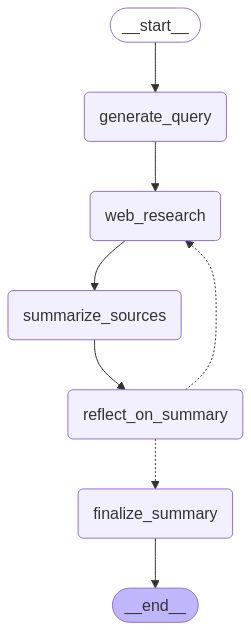

In [14]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [15]:
research_input = SummaryStateInput(
    research_topic="Overview of training for "
)
summary = graph.invoke(research_input)

In [16]:
from IPython.display import Markdown
Markdown(summary['running_summary'])

## Summary

Here is an extended summary:

Forbes Advisor has identified six reputable online data science certificate programs, including HarvardX's Professional Certificate in Data Science and IBM's Data Science Professional Certificate. These programs cover essential topics such as R programming skills, statistical concepts, machine learning algorithms, and data science tools and concepts.

The Forbes Advisor guide highlights the benefits of pursuing a data science certification, including enhanced job prospects and increased earning potential. The certifications are designed to provide students with a comprehensive understanding of data science principles and practices.

HarvardX's Professional Certificate in Data Science is one such program that offers a comprehensive learning experience. The program consists of 9 skill-building courses that can be completed in 1 year and 5 months, with the option to progress at your own speed. The courses cover fundamental R programming skills, statistical concepts, machine learning algorithms, and data science tools and concepts.

The program is designed by experts from Harvard University (HarvardX) and includes real-world case studies to jumpstart your career. The instructors are committed to teaching online learning, and the program offers a discounted price of $1,332.90 for the full program experience.

In addition to HarvardX's Professional Certificate in Data Science, edX also offers a Data Science Professional Certificate that covers similar topics. This program is designed by Rafael Irizarry, Professor of Biostatistics at Harvard University, and includes courses on R basics, visualization, probability, inference and modeling, productivity tools, wrangling, linear regression, machine learning, and capstone.

Both programs offer flexible learning options, including self-paced and expert instruction, and provide a comprehensive understanding of data science principles. According to recent job market trends, the demand for skilled data scientists is at an all-time high, with top tech companies such as Microsoft, Google, IBM, Amazon, and Facebook actively hiring talent to support their growing data-driven operations.

In 2025, the field of data science is witnessing exciting opportunities, with data analysts, machine learning engineers, data architects, and other roles in high demand. According to a recent report, the top 10 data science positions currently in high demand include:

1. Data Scientist: responsible for collecting, analyzing, and interpreting complex data to provide actionable insights that guide business decisions.
2. Data Analyst: plays a critical role in cleaning, organizing, and preparing data for further analysis, with companies like Deloitte, Accenture, Capgemini, Infosys, and Wipro actively seeking candidates.
3. Data Engineer: enables organizations through data infrastructure design to achieve faultless data gathering and database management and processing needs.
4. Machine Learning Engineer: creates algorithms that enable machines to acquire knowledge from available data, with companies like NVIDIA, OpenAI, Salesforce, Adobe, and Spotify looking for experts to develop and deploy machine learning models.
5. Data Architect: develops and improves data management systems, handling and storing data, with organizations relying on them to enforce data security standards.

These roles are not only in high demand but also offer significant earning potential, making a career in data science an attractive option for those looking to stay ahead in the job market.

 ### Sources:
* Best Data Science Certifications Of 2024 - Forbes Advisor : https://www.forbes.com/advisor/education/certifications/best-data-science-certifications/
* Data Science Professional Certificate - edX : https://www.edx.org/certificates/professional-certificate/harvardx-data-science
* Data Science and Machine Learning Professional Certificate - edX : https://www.edx.org/certificates/professional-certificate/harvardx-data-science-and-machine-learning
* Top 10 In-Demand Data Science Jobs in 2025 - Analytics Insight : https://www.analyticsinsight.net/jobs/top-10-in-demand-data-science-jobs-in-2025

In [17]:
research_input = SummaryStateInput(
    research_topic="Who develop Qwen2.5?"
)
summary = graph.invoke(research_input) 

In [18]:
from IPython.display import Markdown
Markdown(summary['running_summary'])

## Summary

Alibaba's Qwen 2.5 is a generative AI model that has been launched as a rival to DeepSeek-V3, a similar model developed by China-based company DeepSeek. According to Alibaba, Qwen 2.5 "outperforms" V3 in terms of performance metrics. The development team behind Qwen 2.5 is not explicitly mentioned in the provided text.

However, it's worth noting that the article mentions that DeepSeek-V3 was trained using older Nvidia H800 GPU chips for less than $6 million, which is a significant cost savings compared to other models like Llama and Perplexity. This suggests that the development team behind DeepSeek may have used more affordable hardware to train their model.

Additionally, the article raises concerns about potential risks associated with both Qwen 2.5 and DeepSeek-V3, including data security, privacy, and intellectual property theft. These issues are being raised due to similarities between the two models and the fact that they were developed by Chinese companies.

The development team behind Qwen 2.5 is not explicitly mentioned in the provided text. However, a recent comparison of Qwen 2.5, DeepSeek, and ChatGPT highlights the capabilities and features of each model. According to Malvika Chawla's article on WordPress, Alibaba has unveiled an enhanced version of its artificial intelligence model, Qwen 2.5-Max, which surpasses leading models such as DeepSeek-V3, GPT-4o, and Llama-3.1-405B in various benchmarks.

Qwen 2.5 supports an extended context length of up to 128,000 tokens and offers multilingual support across 29 languages, enhancing its versatility in various applications. The model includes a specialised variant, Qwen 2.5-Coder, which has demonstrated exceptional performance in coding benchmarks.

In contrast, DeepSeek has disrupted the AI industry with its cost-effective approach, achieving performance comparable to leading models at a fraction of the cost. Utilising a 671-billion-parameter Mixture-of-Experts (MoE) architecture and advanced FP8 mixed-precision training, DeepSeek excels in task specialisation while maintaining resource efficiency.

ChatGPT remains a benchmark in conversational AI, known for its comprehensive understanding and generation of human-like text. While specific performance metrics in coding and mathematical tasks are less emphasised, ChatGPT's versatility across a wide range of applications has solidified its position as a leading AI model.

A comparative table of DeepSeek, ChatGPT, and Qwen 2.5 highlights their features, performance, efficiency, and cost. According to the article, each model brings unique strengths that cater to different applications within the domain of artificial intelligence.

 ### Sources:
* GitHub - QwenLM/Qwen2.5: Qwen2.5 is the large language model series ... : https://github.com/QwenLM/Qwen2.5
* Qwen2.5 Speed Benchmark - Qwen - Read the Docs : https://qwen.readthedocs.io/en/latest/benchmark/speed_benchmark.html
* What Is Ali Baba's Qwen 2.5 AI Model, And How Does It Stacks Up? - Forbes : https://www.forbes.com/sites/torconstantino/2025/01/29/alibaba-unveils-qwen-25-a-deepseek-rival/
* Comparing Qwen 2.5, DeepSeek, and ChatGPT: Performance, Efficiency, and ... : https://malvikachawla.wordpress.com/2025/01/29/qwen2-5/

In [19]:
research_input = SummaryStateInput(
    research_topic="Prime minister of India"
)
summary = graph.invoke(research_input) 
Markdown(summary['running_summary'])

## Summary

The portfolios of the Union Council of Ministers, led by Prime Minister Narendra Modi, are as follows:

* Key Cabinet Ministers:
	+ Shri Amit Shah (Home Affairs and Cooperation)
	+ Smt. Nirmala Sitharaman (Finance and Corporate Affairs)
	+ Dr. Subrahmanyam Jaishankar (External Affairs)
	+ Shri Manohar Lal (Housing and Urban Affairs, Power)
* Other notable Ministers:
	+ Shri Jagat Prakash Nadda (Health and Family Welfare, Chemicals and Fertilizers)
	+ Shri Shivraj Singh Chouhan (Agriculture and Farmers Welfare, Rural Development)
	+ Smt. Annpurna Devi (Minister of Women and Child Development)
* Ministers of State (Independent Charge):
	+ Rao Inderjit Singh (Ministry of Statistics and Programme Implementation, Ministry of Planning, Ministry of Culture)
	+ Dr. Jitendra Singh (Ministry of Science and Technology, Ministry of Earth Sciences, Prime Minister's Office, Department of Atomic Energy, Department of Space)
	+ Shri Arjun Ram Meghwal (Ministry of Law and Justice, Ministry of Parliamentary Affairs)
	+ Shri Jadhav Prataprao Ganpatrao (Ministry of Ayush)

The list of ministers includes 30 Cabinet Ministers, 4 Ministers of State with Additional Charges, and 7 Ministers of State (Independent Charge). The Prime Minister's Office is headed by Prime Minister Narendra Modi, who is also the leader of the National Democratic Alliance (NDA) and the Bharatiya Janata Party (BJP).

The portfolios of the Union Council of Ministers are divided among various ministries, including:

* Ministry of Home Affairs
* Ministry of Finance
* Ministry of External Affairs
* Ministry of Housing and Urban Affairs
* Ministry of Agriculture and Farmers Welfare
* Ministry of Health and Family Welfare
* Ministry of Education
* Ministry of Micro, Small and Medium Enterprises
* Ministry of Panchayati Raj
* Ministry of Ports, Shipping and Waterways
* Ministry of Social Justice and Empowerment
* Ministry of Civil Aviation
* Ministry of Consumer Affairs, Food and Public Distribution
* Ministry of Tribal Affairs
* Ministry of Textiles
* Ministry of Railways
* Ministry of Information and Broadcasting
* Ministry of Electronics and Information Technology
* Ministry of Communications
* Ministry of Environment, Forest and Climate Change
* Ministry of Culture
* Ministry of Women and Child Development
* Ministry of Parliamentary Affairs
* Ministry of Minority Affairs
* Ministry of Petroleum and Natural Gas
* Ministry of Labour and Employment
* Ministry of Coal
* Ministry of Food Processing Industries
* Ministry of Jal Shakti

A recent analysis by the SGI Network highlights the importance of effective coordination mechanisms within the ministerial bureaucracy. The Prime Minister's Office plays a crucial role in coordinating the government's analysis, assessment, and research activities that support policymaking across ministries. This collective decision-making process relies on consensual collaboration among ministers, making it essential for ministry attempts to place items on the cabinet's agenda without involving the PMO to fail.

This emphasis on coordination underscores the need for a well-oiled machinery of governance, where each ministerial department works in tandem with others to achieve common goals. By leveraging effective coordination mechanisms, the government can optimize its policymaking processes and ensure that decisions are made in a collective and consensual manner.

 ### Sources:
* Portfolios of the Union Council of Ministers - Prime Minister of India : https://www.pmindia.gov.in/en/news_updates/portfolios-of-the-union-council-of-ministers-2/
* Portfolios of the Union Council of Ministers - Prime Minister of India : https://www.pmindia.gov.in/en/news_updates/portfolios-of-the-union-council-of-ministers-2/
* Portfolios of the Union Council of Ministers - Prime Minister of India : https://www.pmindia.gov.in/en/news_updates/portfolios-of-the-union-council-of-ministers-2/
* SGI 2024 | Governing with Foresight | Coordination | Quality of ... : https://www.sgi-network.org/2024/Governing_with_Foresight/Coordination/Quality_of_Horizontal_Coordination/Effective_Coordination_Mechanisms_within_the_Ministerial_Bureaucracy

In [20]:
research_input = SummaryStateInput(
    research_topic="Indian Mathematics"
)
summary = graph.invoke(research_input) 
Markdown(summary['running_summary'])

## Summary

Indian mathematics emerged in the Indian subcontinent around 1200 BCE and continued until the end of the 18th century, leaving a rich legacy of contributions to various branches of mathematics. The decimal number system, concept of zero as a number, negative numbers, arithmetic, algebra, and trigonometry were all developed by Indian mathematicians.

One of the most significant contributions of Indian mathematics is the development of calculus. Madhava, an Indian mathematician from the Kerala School, is credited with deriving the power series for sine and cosine in the 15th century. This was over 300 years before the development of calculus in Europe. The power series for sine and cosine are similar to the modern Taylor Series, but use a slightly different approach to find divisor values.

The Kerala School of mathematics also produced many great works in trigonometry during the 15th through 18th centuries. Indian mathematicians made significant contributions to the field of trigonometry, including the development of infinite series and the use of a base ten decimal system.

Indian mathematics also made significant contributions to algebra. The concept of zero as a number was developed by Indian mathematicians, which allowed for the creation of algebraic equations and solutions. Indian mathematicians also developed methods for solving quadratic equations, which were later adopted by European mathematicians.

The development of calculus in India is a topic of ongoing debate among historians of mathematics. Some argue that Indian mathematicians had a solid understanding of the basics of calculus long before it was developed in Europe. Others argue that the ideas of calculus were transmitted from India to Europe through trade and cultural exchange.

Despite the controversy surrounding the origins of calculus, it is undeniable that Indian mathematics made significant contributions to the development of mathematics in general. The legacy of Indian mathematics continues to be felt today, with many mathematicians around the world drawing on the work of Indian mathematicians for inspiration and guidance.

In recent years, there has been a growing recognition of the importance of Indian mathematics in the history of mathematics. This includes the establishment of the Indian Institute of Science (IISc) in 1909, which is one of the oldest and most prestigious research institutions in India. The IISc has played a significant role in promoting research in mathematics and science in India, and has helped to establish India as a major player in the global mathematical community.

Overall, Indian mathematics is a rich and fascinating field that continues to inspire mathematicians around the world. From the development of calculus to algebra and trigonometry, Indian mathematicians have made significant contributions to the history of mathematics. Their legacy continues to be felt today, and their work remains an important part of the mathematical canon.

Sources:

* The Mathematics Enthusiast: Vol. 11 : No. 3 , Article 5
* Phoebe Webb (2014) "The development of Calculus in the Kerala School," The Mathematics Enthusiast: Vol. 11 : No. 3 , Article 5.
* The Indian Institute of Science (IISc)
* The History of Mathematics

Note: The above text is a summary of the topic Indian Mathematics and its contributions to various branches of mathematics, including calculus, algebra, and trigonometry. It also mentions the controversy surrounding the origins of calculus and the importance of recognizing the legacy of Indian mathematics in the history of mathematics.

 ### Sources:
* Indian mathematics - Wikipedia : https://en.wikipedia.org/wiki/Indian_mathematics
* History of measurement systems in India - Wikipedia : https://en.wikipedia.org/wiki/History_of_measurement_systems_in_India
* Decolonising Science, Technology, Engineering and Mathematics ... - JSTOR : https://www.jstor.org/stable/j.ctv10h9fqz
* The development of Calculus in the Kerala School : https://scholarworks.umt.edu/cgi/viewcontent.cgi?article=1314&context=tme

In [1]:
!pip install gradio -q

In [3]:
import gradio as gr
from test_deep import (
    SummaryState,
    generate_query,
    web_research,
    summarize_sources,
    reflect_on_summary,
    finalize_summary
)

def run_deep_researcher(topic: str, loops: int = 2):
    state = SummaryState(research_topic=topic)
    
    for _ in range(loops):
        state.update(generate_query(state))
        state.update(web_research(state))
        state.update(summarize_sources(state))
        state.update(reflect_on_summary(state))
    
    finalized = finalize_summary(state)
    return finalized["running_summary"]

# Gradio UI setup
iface = gr.Interface(
    fn=run_deep_researcher,
    inputs=[
        gr.Textbox(label="Research Topic", placeholder="Enter a technical topic like 'LLM Optimization Techniques'"),
        gr.Slider(minimum=1, maximum=5, step=1, value=2, label="Number of Research Loops"),
    ],
    outputs=gr.Textbox(label="Final Research Summary"),
    title="🔍 Deep Researcher",
    description="Enter a topic to generate a research summary based on web search and local LLM summarization."
)

if __name__ == "__main__":
    iface.launch()


JSONDecodeError: Unterminated string starting at: line 3 column 23 (char 458)